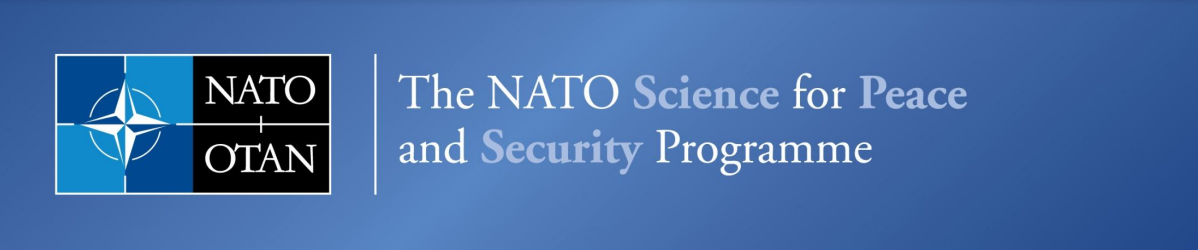

In [1]:
from IPython.display import Image
img_path = r"C:\Users\hp\Pictures\Screenshots\Screenshot 2024-08-07 134548.png"
Image(filename=img_path, width=1000, height=1500)

# Building Time Series model using Prophet
## SST in Time Series / Antalya - NATO Science for Peace and Security (SPS) Programme

## Abdallah I. J. Dwikat - Intern at NATO (SPS) Programme - Computer Engineering Department

### In this directory, will 1) apply SST TS daily data into Prophet model, 2) evaluate the model, and then 3) make future predictions

### Prophet is an open-source forecasting tool developed by group of Data Scientists in Facebook (now Meta) designed for time series data. It is particularly useful for handling data with strong seasonal effects and missing data points. Prophet uses an additive model to fit non-linear trends with yearly, weekly, and daily seasonality, along with holiday effects. SST data is affected by seasonality such asin summer the SST is higher than winter which these trends aligns well with Prophet model, and also our data is on daily basis which fits in Prophet as well.

####  “Additive” means that the different components (like trend, seasonality, and holidays) are added together to form the final forecast. This is in contrast to “Multiplicative” models where components are multiplied together.

### Additive model can be represented as:
### yt​=Tt​+St​+Ct​+Rt​    

### ( y_t ) is the observed value at time ( t )
### ( T_t ) is the trend component
### ( S_t ) is the seasonal component
### ( C_t ) is the cyclical component
### ( R_t ) is the random error component

###  Multiplicative model can be represented as: 
### yt​=Tt​×St​×Ct​×Rt​

### ( y_t ) is the observed value at time ( t )
### ( T_t ) is the trend component
### ( S_t ) is the seasonal component
### ( C_t ) is the cyclical component
### ( R_t ) is the random error component

## Background on the Types of Time Series Data

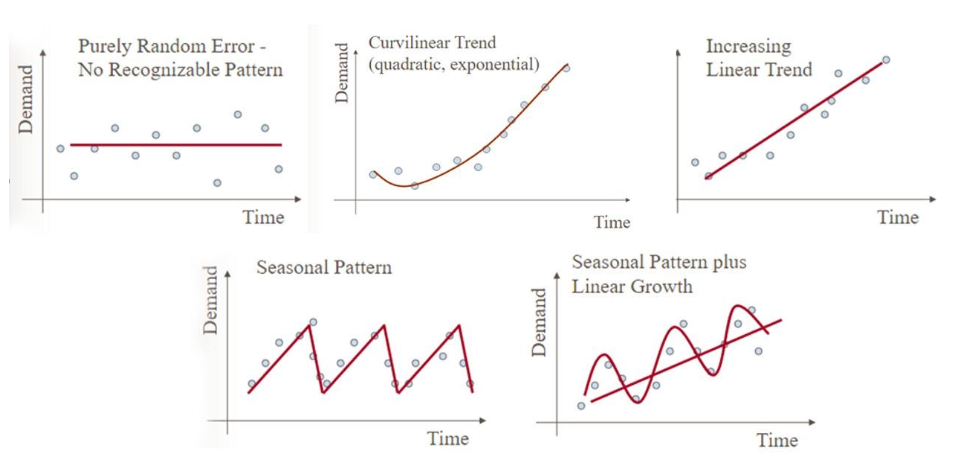

In [2]:
from IPython.display import Image
img_path = r"C:\Users\hp\Pictures\Screenshots\Screenshot 2024-08-07 133433.png"
Image(filename=img_path, width=1000, height=1500)

# Start by importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import  mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## load data

In [5]:
path = r"C:\Users\hp\Research-Try-ML\Models\SST-Antalya-2007-2023-Cleaned.csv"
df = pd.read_csv(path)
df.head()

,Date,SST
0,1-Jan-07,17.9
1,2-Jan-07,17.9
2,3-Jan-07,17.7
3,4-Jan-07,17.5
4,5-Jan-07,17.4


## Ensure to convert Date into date_timme data type

In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [7]:
print(df['Date'].isna().sum())


0


## Assign Date as the index

In [8]:
df.set_index('Date', inplace=True)

In [9]:
df.head(2)

,SST
Date,
2007-01-01,17.9
2007-01-02,17.9


## Visualization

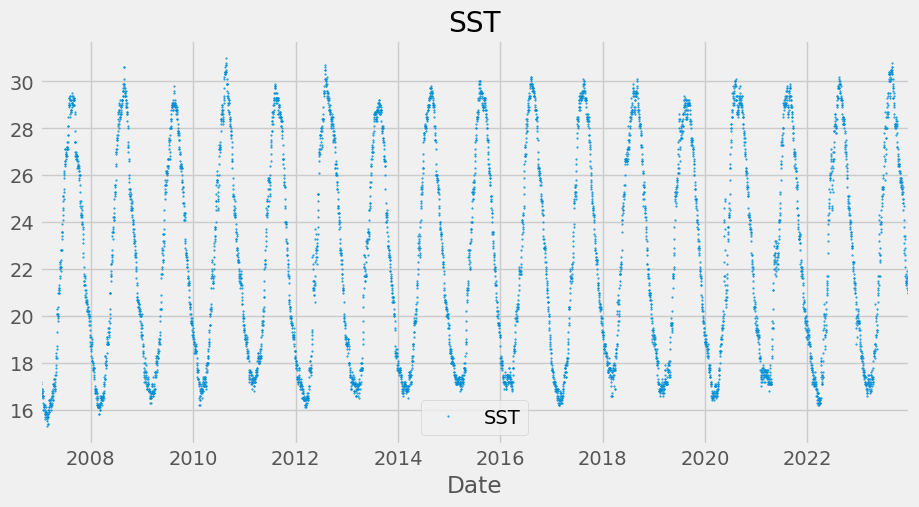

In [10]:
color_pal = sns.color_palette()
df.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='SST')
plt.show()

# Time Series features

In [11]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['weekday'] = df['Date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear  # Fixed indentation
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week  # Updated for pandas 1.1.0+
    df['date_offset'] = (df.Date.dt.month*100 + df.Date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear','weekday',
            'season']]
    
    if label:
        y = df[label]
        return X, y
    return X

# Assuming 'pjme' is your DataFrame and 'SST' is the label column
X, y = create_features(df, label='SST')
features_and_target = pd.concat([X, y], axis=1)


## now we have the data splitted into time series with days/weeks/weekday..etc.

In [12]:
features_and_target

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,SST
Date,,,,,,,,,,
2007-01-01,0,1,1,2007,1,1,1,Monday,Winter,17.9
2007-01-02,1,1,1,2007,2,2,1,Tuesday,Winter,17.9
2007-01-03,2,1,1,2007,3,3,1,Wednesday,Winter,17.7
2007-01-04,3,1,1,2007,4,4,1,Thursday,Winter,17.5
2007-01-05,4,1,1,2007,5,5,1,Friday,Winter,17.4
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2,4,12,2023,361,27,52,Wednesday,Winter,21.0
2023-12-28,3,4,12,2023,362,28,52,Thursday,Winter,20.8
2023-12-29,4,4,12,2023,363,29,52,Friday,Winter,20.8


## BoxPlot by Year -- Can be changed depending on which feature we find is useful

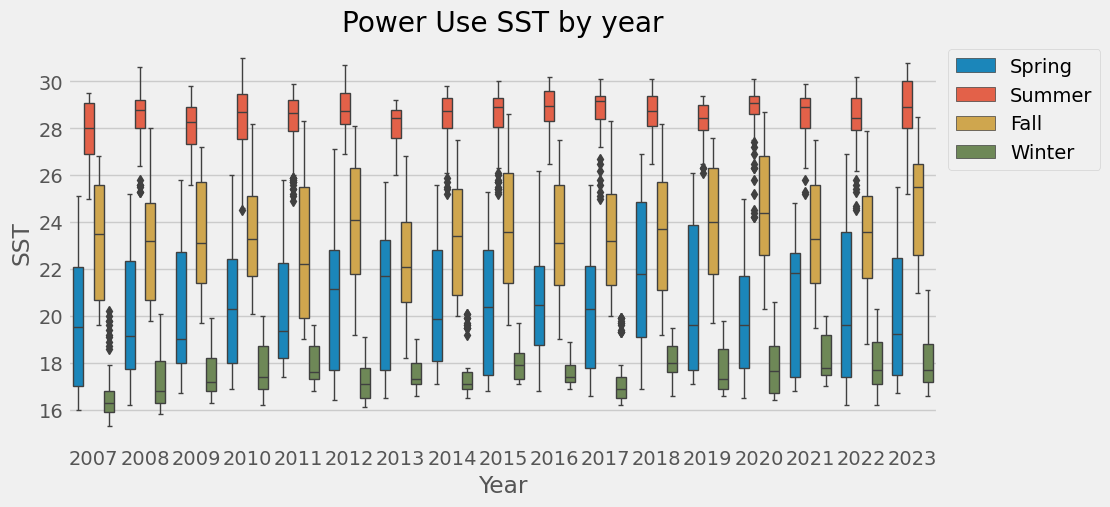

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='year', #From here we an change the feature
            y='SST',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use SST by year')
ax.set_xlabel('Year')
ax.set_ylabel('SST')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

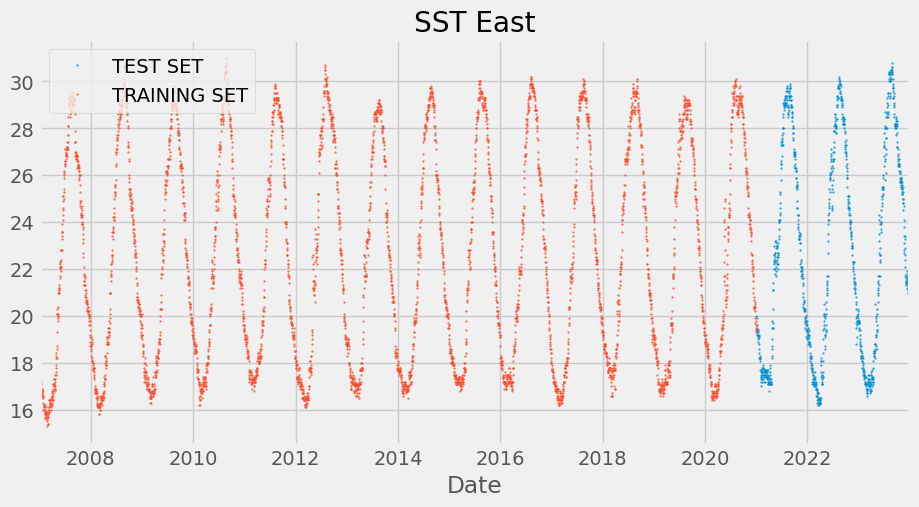

In [14]:
split_date = '1-Jan-2021'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'SST': 'TEST SET'}) \
    .join(df_train.rename(columns={'SST': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='SST East', style='.', ms=1)
plt.show()

# Building Simple Prophet model

### rename the files

In [15]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'SST':'y'})

### ds is the date and y is the target which is SST

In [16]:
df_train_prophet.head(2)

,ds,y
0,2007-01-01,17.9
1,2007-01-02,17.9


# Train the model

In [17]:
%%time
model = Prophet()
model.fit(df_train_prophet)

16:02:14 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 344 ms
Wall time: 3.07 s


# Predict on the test set

In [18]:
df_test_prophet = df_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'SST':'y'})

df_test_fcst = model.predict(df_test_prophet)

In [19]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,22.754561,18.196825,19.626042,22.754561,22.754561,-3.870875,-3.870875,-3.870875,-0.007589,-0.007589,-0.007589,-3.863286,-3.863286,-3.863286,0.0,0.0,0.0,18.883685
1,2021-01-03,22.754294,18.075759,19.521386,22.754294,22.754294,-3.919624,-3.919624,-3.919624,-0.001042,-0.001042,-0.001042,-3.918581,-3.918581,-3.918581,0.0,0.0,0.0,18.834670
2,2021-01-04,22.754027,18.107475,19.485521,22.754027,22.754027,-3.978938,-3.978938,-3.978938,-0.007162,-0.007162,-0.007162,-3.971775,-3.971775,-3.971775,0.0,0.0,0.0,18.775089
3,2021-01-05,22.753760,18.054293,19.391762,22.753760,22.753760,-4.014994,-4.014994,-4.014994,0.007945,0.007945,0.007945,-4.022940,-4.022940,-4.022940,0.0,0.0,0.0,18.738766
4,2021-01-06,22.753493,17.935623,19.352284,22.753493,22.753493,-4.069655,-4.069655,-4.069655,0.002521,0.002521,0.002521,-4.072176,-4.072176,-4.072176,0.0,0.0,0.0,18.683838


## we can see more than only y as this is an additive model so it shows each component of the prediction in our output

## visualization of the result

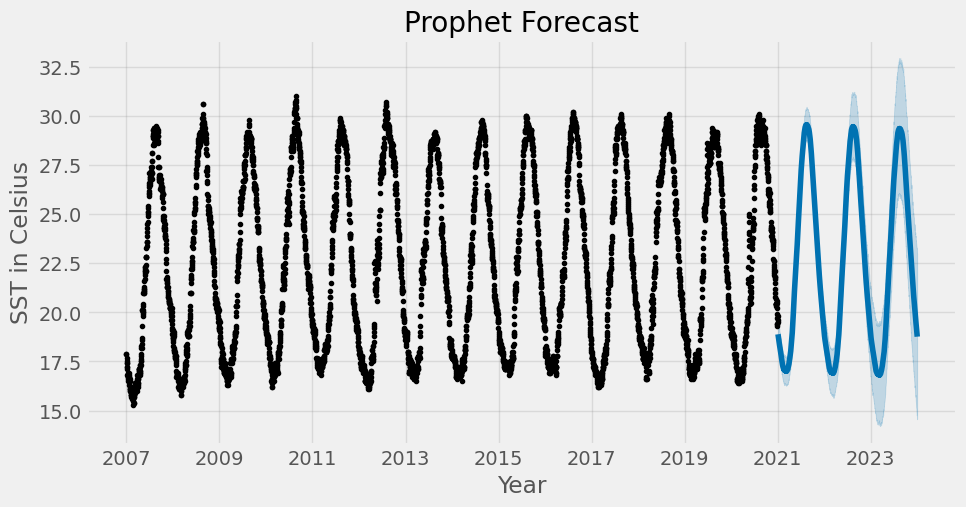

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.xlabel("Year")
plt.ylabel("SST in Celsius")
plt.show()

## Note from plot that values becoming wider with predicting further years....

## Plot Components

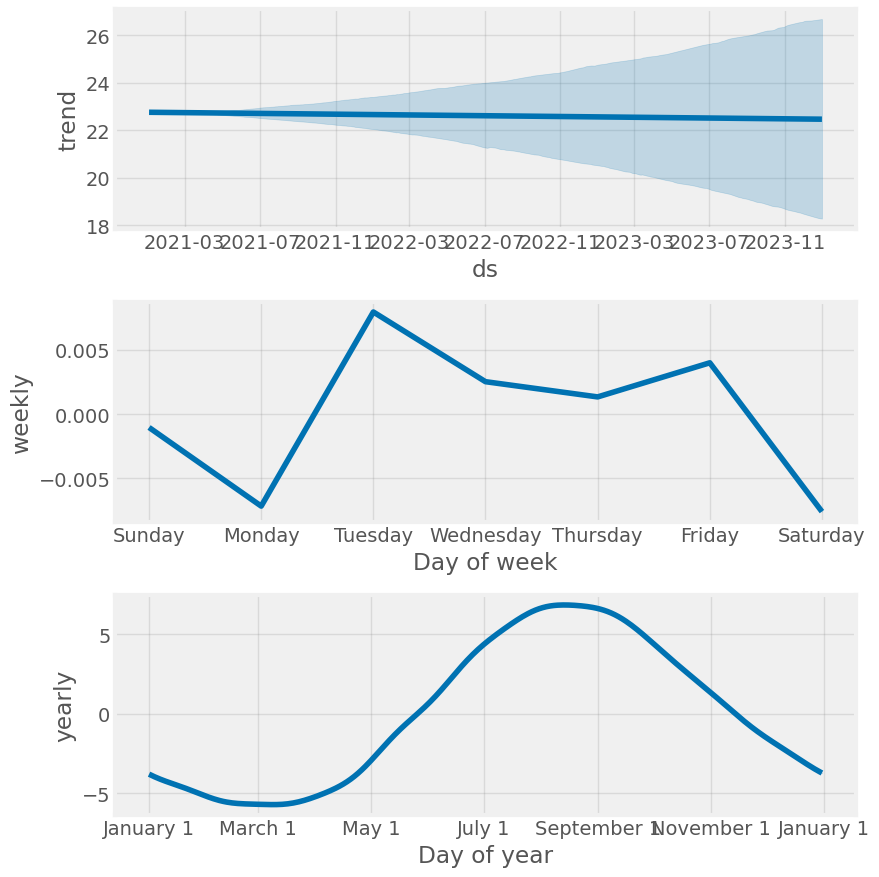

In [21]:
fig = model.plot_components(df_test_fcst)
plt.show()

## Plot forecasts with the actuals

Text(0, 0.5, 'SST IN CELSIUS')

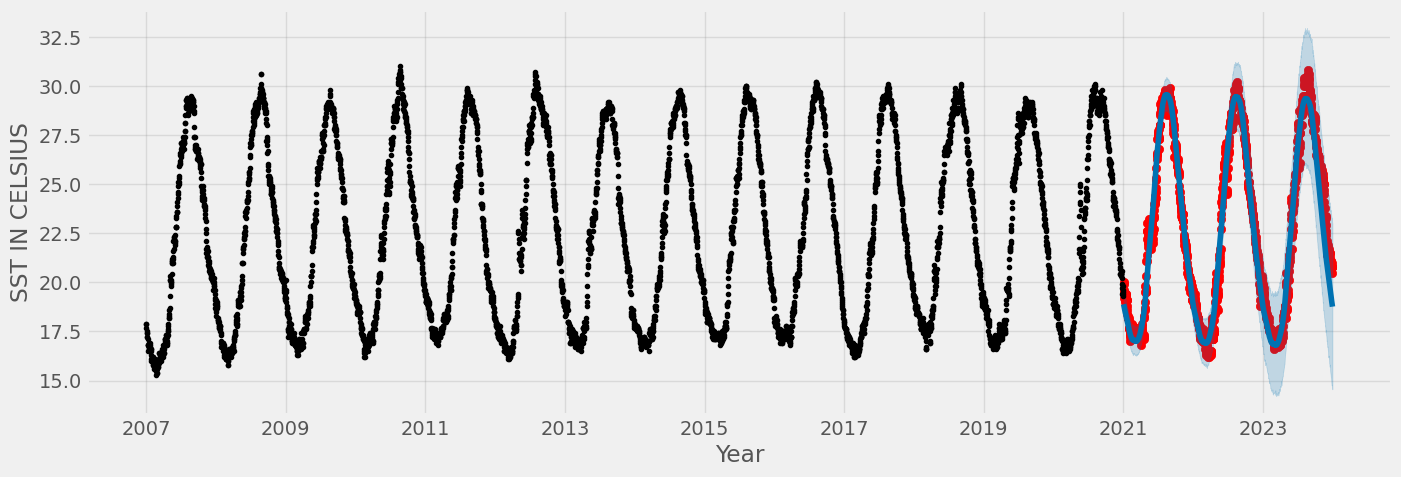

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['SST'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
plt.xlabel("Year")
plt.ylabel("SST IN CELSIUS")

## For easier compare, this is plot for the 1st month only

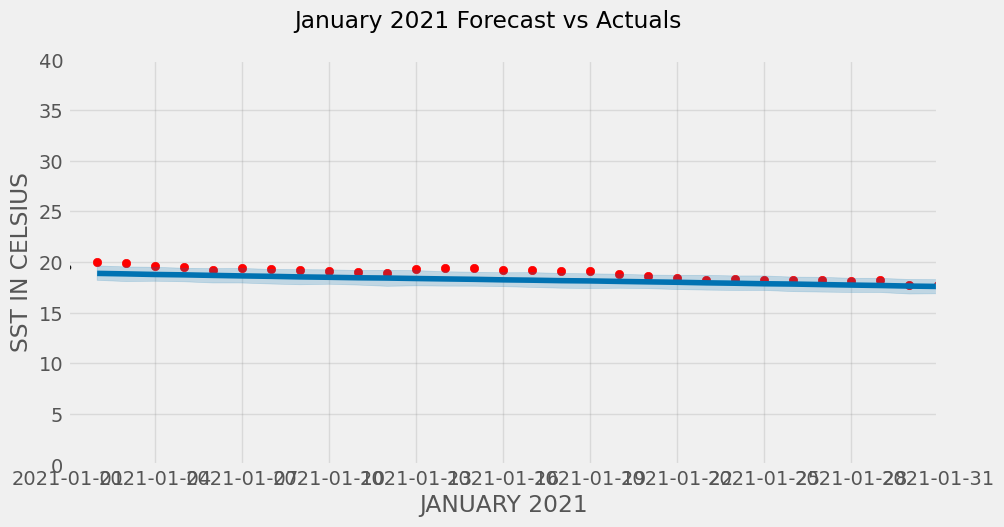

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['SST'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

# Convert string dates to datetime objects
lower_date = datetime.strptime('01-01-2021', '%d-%m-%Y')
upper_date = datetime.strptime('31-01-2021', '%d-%m-%Y')

# Correct usage of set_xlim
ax.set_xlim(lower_date, upper_date)
ax.set_ylim(0, 40)
plt.suptitle('January 2021 Forecast vs Actuals')
plt.ylabel("SST IN CELSIUS")
plt.xlabel("JANUARY 2021")

plt.show()

# Plot for the First week prediction

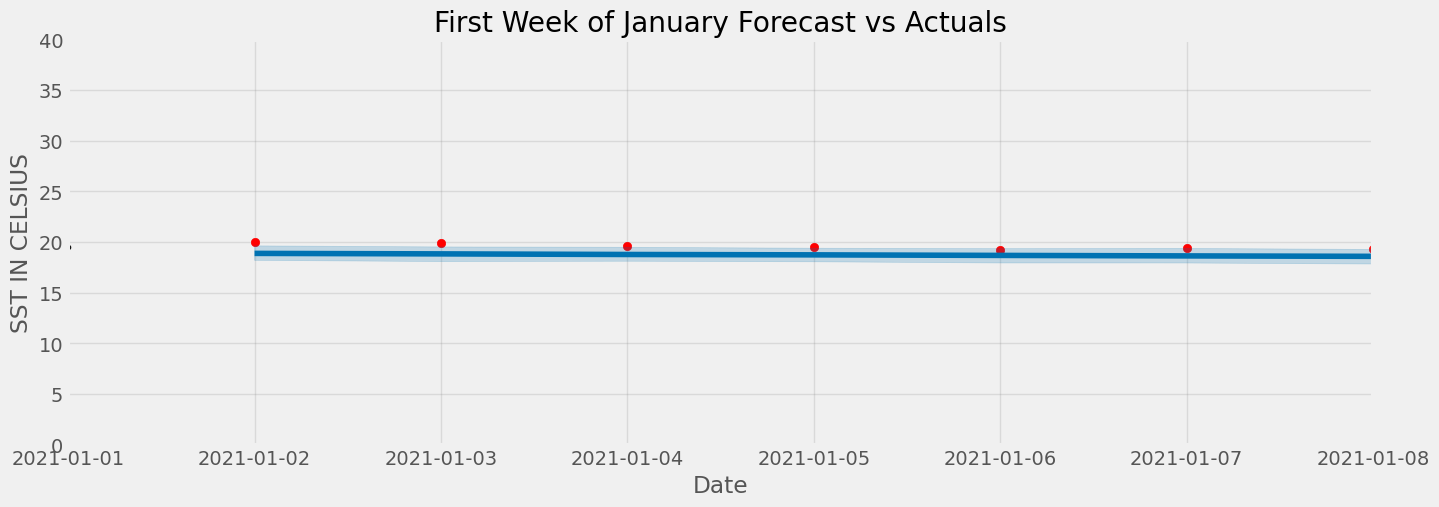

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['SST'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

# Convert string dates to datetime objects
lower_date = datetime.strptime('01-01-2021', '%d-%m-%Y')
upper_date = datetime.strptime('08-01-2021', '%d-%m-%Y')

ax.set_xbound(lower_date, upper_date)
ax.set_ylim(0, 40)
ax.set_title('First Week of January Forecast vs Actuals')
plt.xlabel("Date")
plt.ylabel("SST IN CELSIUS")
plt.show()


# Model Evaluation Metrics

### Mean Squared Error

In [25]:
np.sqrt(mean_squared_error(y_true=df_test['SST'],
                   y_pred=df_test_fcst['yhat']))

0.7692350858018381

### Mean Absolute Error

In [26]:
mean_absolute_error(y_true=df_test['SST'],
                   y_pred=df_test_fcst['yhat'])

0.5817434190983843

### Mean Absolute Percentage Error

In [27]:
mean_absolute_percentage_error(y_true=df_test['SST'],
                   y_pred=df_test_fcst['yhat'])

2.6307993090096966

### Accuarcy

In [28]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_true=df_test['SST'], y_pred=df_test_fcst['yhat'])

# Calculate accuracy percentage
accuracy_percentage = (1 - mape) * 100

print(f"MAPE: {mape:.4f}")
print(f"Accuracy: {accuracy_percentage:.2f}%")

MAPE: 2.6308
Accuracy: -163.08%


# Now let's Predict future till end of 2024!

In [29]:
# Create future dates for prediction
future = model.make_future_dataframe(periods=365*4, freq='D', include_history=False)

# Make predictions
forecast = model.predict(future)

In [30]:
forecast[['ds','yhat']]

,ds,yhat
0,2021-01-02,18.883685
1,2021-01-03,18.834670
2,2021-01-04,18.775089
3,2021-01-05,18.738766
4,2021-01-06,18.683838
...,...,...
1455,2024-12-27,18.882622
1456,2024-12-28,18.803255
1457,2024-12-29,18.743850
1458,2024-12-30,18.673734


## Output: 
### The Accuray of the Prophet model on SST time Series daily data is more than 97%
#### However we noted that whenever the preditions are wider, the reliability in predicting is lower
#### For Example, It is reliable with this model to predcit first couple of months in 2024 if we apply full 2023 data while with 2025 it is less reliable predictions

# With kindest wishes. 
# Abdallah I. J. Dwikat
### email: adweikat12@gmail.com / Linkedin: Abdallah Dwikat